# Import Dataset

In [3]:
import kagglehub ## Kaggle is a Community Site for Data Scientists. There are many cool datasets available there.
## Feel free to work on projects from Kaggle during your free time to gain experience and try out new models!

path = kagglehub.dataset_download("sandhyapalaniappan/rainfall-prediction-dataset-cleaned-weatheraus") ## We are using the Australian Rain Dataset to walk through our code.

print("Path to dataset files:", path)

Path to dataset files: /Users/kaironglee/.cache/kagglehub/datasets/sandhyapalaniappan/rainfall-prediction-dataset-cleaned-weatheraus/versions/1


In [4]:
import pandas as pd ## Pandas is a useful library helps you organise your data into a dataframe.

df = pd.read_csv(path + "/weatherAUS_rainfall_prediction_dataset_cleaned.csv") ## I am reading the imported CSV file into a pandas dataframe
df.head() ## I want to visualise the first 5 columns of the dataframe

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2010-04-30,Adelaide,10.8,21.2,0.0,1.8,6.60,ENE,22.0,ENE,...,66.0,48.0,1028.4,1024.7,4.45,4.51,15.7,21.0,No,No
1,2014-07-22,Adelaide,3.7,19.0,0.0,1.4,7.61,N,24.0,N,...,75.0,32.0,1024.2,1021.1,4.45,4.51,9.6,18.5,No,No
2,2014-07-23,Adelaide,9.6,15.8,0.0,2.6,7.61,NE,52.0,NNE,...,35.0,51.0,1017.9,1011.5,4.45,4.51,14.7,15.4,No,Yes
3,2014-07-24,Adelaide,10.1,15.5,16.6,0.8,7.61,NNE,50.0,NW,...,96.0,80.0,1007.4,1008.0,4.45,4.51,11.2,14.0,Yes,Yes
4,2014-07-25,Adelaide,11.2,16.2,1.8,0.6,7.61,NW,30.0,WNW,...,89.0,70.0,1018.4,1019.2,4.45,4.51,13.0,15.3,Yes,Yes


# Data Cleaning

IMPORTANT TO NOTE: PCA and UMAP works mainly on Continuous Data. They will struggle greatly in Categorical Data because these models still rely on Euclidean distance.

*   However, when facing a dataset with many categorical variables, there are some techniques that you can use to transform these variables into something meaningful.
*   Some techniques are used in the code below.
*   Generally, as a rule of thumb, Nominal data needs careful handling. Some techniques that are commonly used are: One-hot Encoding, Embedding and Target Encoding.
*   Ordinal data is slightly better because there is natural order (e.g., low < medium < high), so it can often be represented numerically.
* However, you should ensure that the numeric spacing between levels makes sense for your problem.

In [5]:
import numpy as np ## Numpy is a useful numerical computation library in python. It goes hand in hand with Pandas and you will be interacting with it a lot.

binary_map = {'No': 0, 'Yes': 1}
## The technique used here is Binary Encoding (a special case of Label Encoding).
## Binary data such as Yes/No is transformed into numeric values (0s and 1s).
## This allows the model to compute distances and relationships meaningfully.

df['RainTomorrow'] = df['RainTomorrow'].map(binary_map)
df['RainToday'] = df['RainToday'].map(binary_map)

## Take note that while I have transformed these data into numerical values, they still represent categorical variables.

wind_dir_map = {
    "N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5,
    "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
    "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5,
    "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5
}

for col in ["WindGustDir", "WindDir9am", "WindDir3pm"]:
    df[col] = df[col].map(wind_dir_map)
## In this example, wind direction may look like a categorical variable with many labels.
## However, it actually has a natural circular structure — directions can be represented as degrees on a compass.
## By converting them into angles, we give the model a sense of distance between directions.
## For instance, “N” and “NE” are close together, while “N” and “S” are opposite.
## This is a good example of how understanding the meaning of your data helps you create more informative features.

df["Date"] = pd.to_datetime(df["Date"])

df["Month"] = df["Date"].dt.month
## In this dataset, it’s more meaningful to study weather on a monthly rather than daily basis.
## Weather patterns typically follow seasonal cycles, where conditions repeat roughly every year.
## By extracting the month from the date, we capture this cyclical behavior while smoothing out daily noise.

df = df.drop(columns=["Date", "Location"])
## I opted to leave out Location from this dataset because because encoding it as simple numbers would not add meaningful information.
## However, you could think about ways to make this variable meaningful!
## One suggestion will be to replace location with its latitude and longditute.

df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)
df = df.drop(columns=["Month"])
## I opted to transform the data another time by using sine cosine transformation.
## This is because the month of a calender wraps around. December is close to January.
## However, if I leave this as pure numerical values (1-12), the computer with interpret it as December being furthest from January when they are adjacent.
## You could use the same technique to transfrom the direction variables. (0° is numerically far from 350°, but on a compass, they are close together)
## I did not do it, but try it out and see what happens!

df.head() ## Look through the first 5 columns of your data to make sure that your transformations are correctly implemented.

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month_sin,Month_cos
0,10.8,21.2,0.0,1.8,6.60,67.5,22.0,67.5,315.0,9.0,...,1028.4,1024.7,4.45,4.51,15.7,21.0,0,0,0.866025,-0.500000
1,3.7,19.0,0.0,1.4,7.61,0.0,24.0,0.0,22.5,0.0,...,1024.2,1021.1,4.45,4.51,9.6,18.5,0,0,-0.500000,-0.866025
2,9.6,15.8,0.0,2.6,7.61,45.0,52.0,22.5,45.0,9.0,...,1017.9,1011.5,4.45,4.51,14.7,15.4,0,1,-0.500000,-0.866025
3,10.1,15.5,16.6,0.8,7.61,22.5,50.0,315.0,315.0,17.0,...,1007.4,1008.0,4.45,4.51,11.2,14.0,1,1,-0.500000,-0.866025
4,11.2,16.2,1.8,0.6,7.61,315.0,30.0,292.5,292.5,13.0,...,1018.4,1019.2,4.45,4.51,13.0,15.3,1,1,-0.500000,-0.866025


# Split into X and y data

While Unsupervised Learning does not use y data, it is often useful to seperate the y-data from the x-data. Some reasons are listed below
1. We will eventually run supervised learning models on the dataset, we want to focus primarily on underlying structures and patterns in the input variables.
2. keeping y separate also allows us to visualize the results of Unsupervised Learning
  * For example, when plotting PCA, t-SNE, or UMAP, we can color the data points using y.
  * This helps us see whether our unsupervised model naturally groups the data in a way that aligns with the true labels.
  * This is generally more useful for categorical y data such as 'Yes' and 'No' in this dataset.

For continuous y data, you might need to go a step further to run K-Means on your visualisation to see if there are any meaningful clusters.

In [6]:
X = df.drop(columns=["RainTomorrow"])
y = df["RainTomorrow"]

idx = np.random.choice(X.index, size=5000, replace=False)
X_small = X.iloc[idx]
y_small = y.iloc[idx]

## In this step, I am choosing 5000 random points from the dataset.
## Some models such as t-SNE are computationally intensive and will take a longer time to run.
## For the purpose of this workshop, I deliberately chose to reduce number of datapoints so that the session flows more smoothly.
## However, for your own work, do run the unsupervised models on the whole dataset if you can afford it. (Keep in mind time and memory constaints)

# Standardisation

In [7]:
from sklearn.preprocessing import StandardScaler

## As explained in the slides, scaling data is important when dealing with Euclidean distance and PCA.
## Variables with large scales tend to overwhelm distance computation and dominate Principal Components

scaler = StandardScaler() ## This is usually how variables are standardised in python.
y_small = scaler.fit_transform(y_small.values.reshape(-1,1))

X_small = scaler.fit_transform(X_small) # We are going to apply the standardisation and store the results in a new dataframe
X_small = pd.DataFrame(X_small, columns=X.columns)
X_small.head() ## Visualise the new dataframe to double check that you implemented your transformations correctly.

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Month_sin,Month_cos
0,-0.395395,-0.892524,-0.290518,0.012486,0.010468,0.912114,-0.001672,1.265035,0.958630,1.594118,...,-0.101316,-1.737493,-1.284580,-1.552417,-1.222912,-0.183781,-0.785235,-0.545610,-1.246069,0.739317
1,1.447306,1.159597,-0.290518,0.636966,1.198703,-1.746981,-0.233856,-1.179320,1.632803,-0.897679,...,-0.053410,-0.015605,-0.406406,-1.552417,-1.222912,1.590810,1.259614,-0.545610,-1.436147,0.033951
2,0.177545,0.168436,-0.266834,0.012486,0.010468,-1.082207,-0.539362,0.857643,-1.063891,-0.897679,...,-0.436655,0.897745,0.638319,1.540179,-0.017786,-0.030799,0.208389,-0.545610,-1.246069,0.739317
3,-2.067763,-0.697084,-0.290518,-1.110284,0.656955,0.912114,-0.921244,1.468732,0.284456,-0.897679,...,-1.107333,-0.165334,-0.224714,-1.552417,-0.742782,-1.224058,-0.540429,-0.545610,-1.436147,0.033951
4,0.007212,0.545357,-0.124731,-0.333729,1.921035,0.912114,0.224403,1.468732,1.183354,-0.784416,...,-1.203144,-1.647656,-1.587398,-1.552417,-1.703042,0.030394,0.525196,1.832811,-0.017386,1.444683


# PCA

### (a) Scree Plot

Do not be concerned with the details of how to plot these graphs, they are mainly to help you visualise the results easily.

Graph plotting is quite unique to individual style and how you want to present your data.

You will learn more about data visualisation and graph plotting in DSA2101.

For your own projects before you take DSA2101, you can engage ChatGPT/ other LLMS to plot your results for you. They do a pretty decent job.

Things to take note for PCA:
* n_components is the main hyperparameter to focus on in this workshop. It controls how many principal components to keep.
* Other hyperparameters exist (svd_solver, whiten), but they are beyond the scope of this session.
* Feel free to explore them on your own to see their effects.

* You can also specify n_components as a float (e.g., 0.95), which will keep the minimum number of PCs required to explain 95% of the variance.

* Alternatively, you can set n_components='mle' (Maximum Likelihood Estimation) to let PCA automatically choose the number of components. You will learn about MLE in ST2132 so stay tuned!


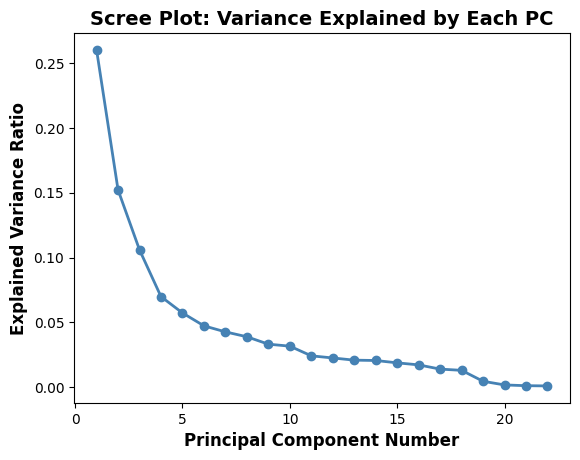

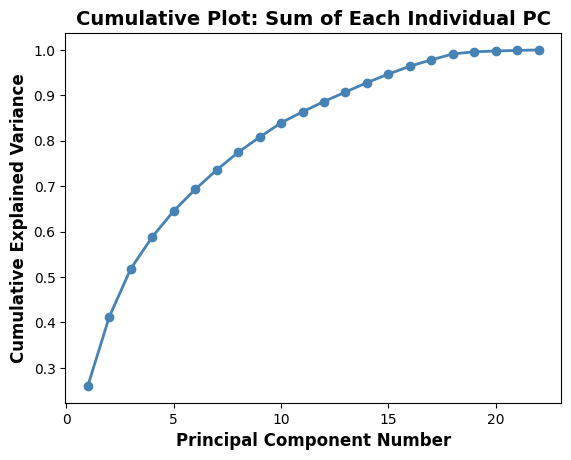

In [8]:
from sklearn.decomposition import PCA # PCA library in python
import matplotlib.pyplot as plt

pca = PCA(n_components = 22, random_state=1000) # there are 22 X-columns in my cleaned dataset. Max PCs = 22
pca.fit(X_small) # this function does the PCA decomposition for you


plt.plot(np.arange(1,23) ,pca.explained_variance_ratio_, marker='o', linestyle='-', linewidth=2, markersize=6, color='steelblue')
plt.xlabel('Principal Component Number', fontsize=12, fontweight='bold')
plt.ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
plt.title('Scree Plot: Variance Explained by Each PC',
              fontsize=14, fontweight='bold')
plt.show()

plt.plot(np.arange(1,23) ,np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', linewidth=2, markersize=6, color='steelblue')
plt.xlabel('Principal Component Number', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
plt.title('Cumulative Plot: Sum of Each Individual PC',
              fontsize=14, fontweight='bold')
plt.show()

### (b) Biplot

Raw loadings values: 
 [[ 3.08681159e-01 -1.71949502e-01]
 [ 3.82957843e-01  4.74362086e-02]
 [-4.60132360e-02 -2.42529417e-01]
 [ 2.47235721e-01  3.74096319e-04]
 [ 1.91652621e-01  2.38060895e-01]
 [-7.23113819e-02 -1.22614965e-01]
 [ 1.03953782e-01 -3.23240090e-01]
 [-7.23436664e-02 -1.56382936e-01]
 [-7.22057673e-02 -1.01666663e-01]
 [ 9.25693234e-02 -2.28592050e-01]
 [ 9.82646648e-02 -2.65539909e-01]
 [-2.77594004e-01 -1.19464858e-01]
 [-2.29213139e-01 -2.55223359e-01]
 [-1.89568367e-01  3.69591784e-01]
 [-2.15429414e-01  3.22395139e-01]
 [-1.30154017e-01 -2.76959134e-01]
 [-1.30559590e-01 -2.84657234e-01]
 [ 3.67676931e-01 -7.96979414e-02]
 [ 3.76615443e-01  7.36020966e-02]
 [-1.14543278e-01 -2.79202647e-01]
 [ 1.03538845e-01 -1.16349660e-02]
 [ 2.58037243e-01 -8.98403518e-02]]


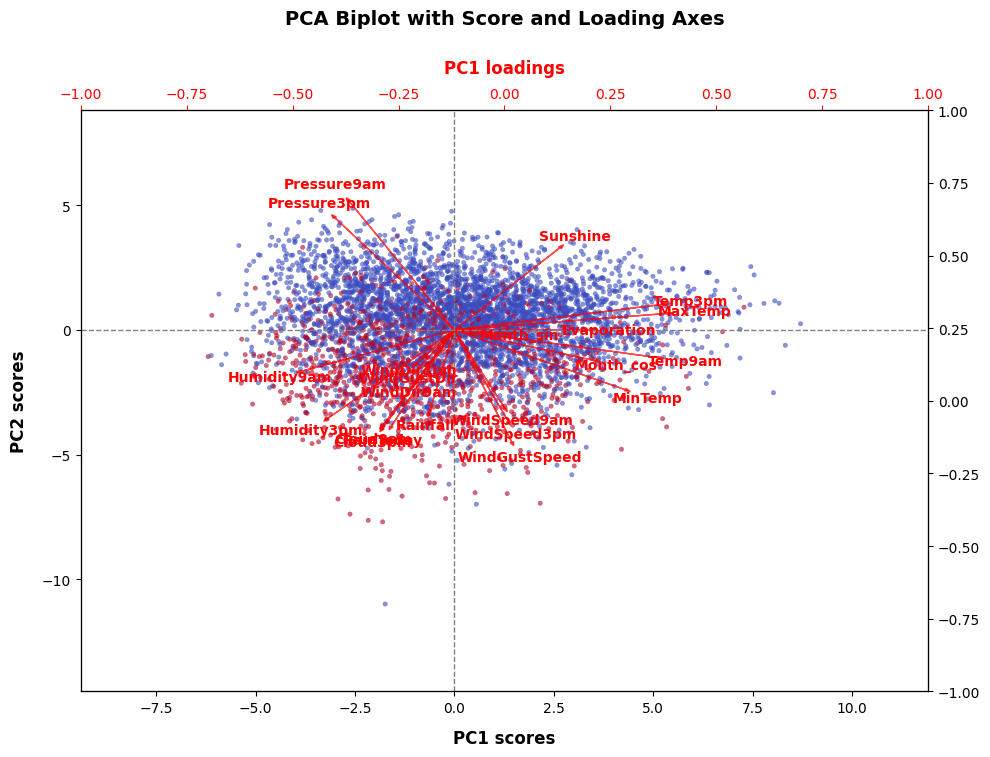

In [9]:
pcaX = pca.transform(X_small)[:, :2]   # first two principal components
loadings = pca.components_.T[:, :2]    # (n_features, 2)
print("Raw loadings values: \n", loadings)
feature_names = X.columns

fig, ax1 = plt.subplots(figsize=(10, 8)) # Create main figure and axis

# Plot data points in a scatter plot using our first two PCs as the axis
sc = ax1.scatter(
    pcaX[:, 0], pcaX[:, 1],
    c=y_small, cmap='coolwarm',
    s=10, alpha=0.6, linewidth=0.3
)

# Label your primary axis -> PCA scores
ax1.set_xlabel("PC1 scores", fontsize=12, fontweight='bold', labelpad=10)
ax1.set_ylabel("PC2 scores", fontsize=12, fontweight='bold', labelpad=10)
ax1.set_title("PCA Biplot with Score and Loading Axes", fontsize=14, fontweight='bold', pad=25)

# Create a secondary axis that records the loading of each feature in the original data set.
ax2 = ax1.twinx().twiny()
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_xlabel("PC1 loadings", fontsize=12, fontweight='bold', color='red', labelpad=10)
ax2.set_ylabel("PC2 loadings", fontsize=12, fontweight='bold', color='red', labelpad=10)
ax2.tick_params(axis='x', colors='red')
ax2.tick_params(axis='y', colors='red')

# Draw out the loading arrows.
scale = (np.max(np.abs(pcaX)) / np.max(np.abs(loadings))) * 0.5
for i, feature in enumerate(feature_names):
    ax1.arrow(0, 0, loadings[i, 0]*scale, loadings[i, 1]*scale,
              color='red', alpha=0.7, head_width=0.1, length_includes_head=True)
    ax1.text(loadings[i, 0]*scale*1.1, loadings[i, 1]*scale*1.1, feature,
             color='red', ha='center', va='center', fontsize=10, fontweight='bold')

# Add reference axis lines
ax1.axhline(0, color="gray", linestyle="--", linewidth=1)
ax1.axvline(0, color="gray", linestyle="--", linewidth=1)

# Formatting and Layout Code
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
x_pad = (xlim[1] - xlim[0]) * 0.15
y_pad = (ylim[1] - ylim[0]) * 0.15
ax1.set_xlim(xlim[0] - x_pad, xlim[1] + x_pad)
ax1.set_ylim(ylim[0] - y_pad, ylim[1] + y_pad)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # adjust the plot so that title is visable

plt.show()

# UMAP

Things to note for UMAP:

* Do note that we need to carefully select the hyperparamters n_neighbours and n_components.
* n_neighbours is the number of neighbours you want to function to consider when building the high dimension and low dimension manifold
* n_components is the number of dimensions you want in visualising the data.

Note: n_components in UMAP is just to specify the number of dimension that you want to visualise your data. There is no direct interpretable meaning to the components of UMAP.

* there are some other hyperparamters that you can play with. Do note that these hyperparamters are out of the scope of our workshop.

1. min_dist -> Controls how tightly points are packed in the low-dimensional embedding
* Small min_dist → clusters are tighter and points of the same cluster are close together.
* Large min_dist → clusters are more spread out, preserving more global relationships.

2. metric -> How do you want the model to compute distance in the high dimension space

    Options:
* Euclidean -> this is what we have gone through in the workshop and is the default for the function hence we do not need to specify it
* Manhattan / City block distance -> Read up on it! It will be taught in IT1244
* Cosine -> Read up on it! Less commonly used distance metric for unsupervised learning. Used commonly in NLP vector stores.

(a) 2D Plots

In [10]:
from umap import UMAP # python library for UMAP

# uncomment below if the above import does not work for you
# from umap.umap_ import UMAP 

umap = UMAP(n_neighbors= 10, n_components= 2, random_state = 1000)
## umap is the library that contains the UMAP function
## We use the UMAP function to help us do our unsupervised learning. It is as simple as just calling the function.


df_umap = umap.fit_transform(X_small) ## this line of code calls umap to do the computation on your data using the hyperparameters set by you earlier.

/Users/kaironglee/projects/sds-workshop/sds_test_venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


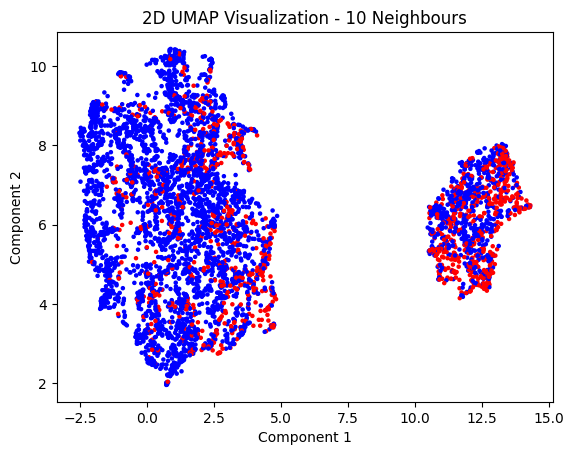

In [11]:
## UMAP Visualisation Plot ## -> 2D/ 10 Neighbours

plt.scatter(df_umap[:, 0], df_umap[:, 1], c=y_small, cmap='bwr', s=5)
plt.title("2D UMAP Visualization - 10 Neighbours")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

It is often interesting to see how varying the number of neighbours affects your visualisation.
* In theory: A higher number of neighbors allows the algorithm to capture more of the global structure in the data.
* In practice: a higher number of neighbours also takes a longer computation time.

You have to go through some trial and error to see what number of neighbours best benefits you.

In [12]:
umap2 = UMAP(n_neighbors=100, n_components = 2, random_state = 1000) ## 100 Neighbours, 2 Dimensions
df_umap2 = umap2.fit_transform(X_small)

/Users/kaironglee/projects/sds-workshop/sds_test_venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


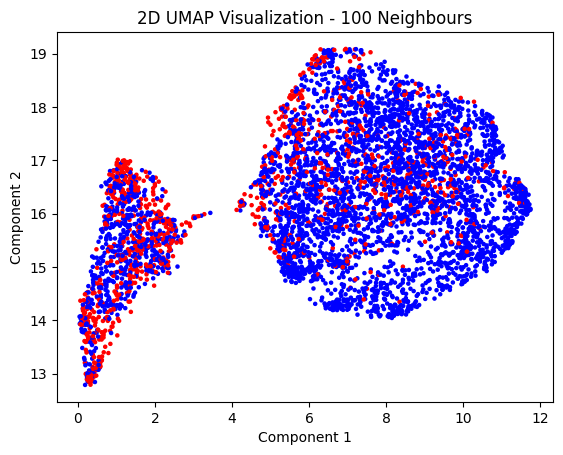

In [13]:
## UMAP Visualisation Plot ## -> 2D/ 100 Neighbours

plt.scatter(df_umap2[:, 0], df_umap2[:, 1], c=y_small, cmap='bwr', s=5)
plt.title("2D UMAP Visualization - 100 Neighbours")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

(b) 3D plots


Sometimes you might miss our important structures in the data when you only visualise in 2 dimensions.

It is often useful to do a 3D plot along with your 2D plot to analyse the overall structure of the data.

This is done by changing n_components from 2 to 3.


In [14]:
umap3 = UMAP(n_neighbors= 10, n_components= 3, random_state = 1000)
df_umap3 = umap3.fit_transform(X_small)

/Users/kaironglee/projects/sds-workshop/sds_test_venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


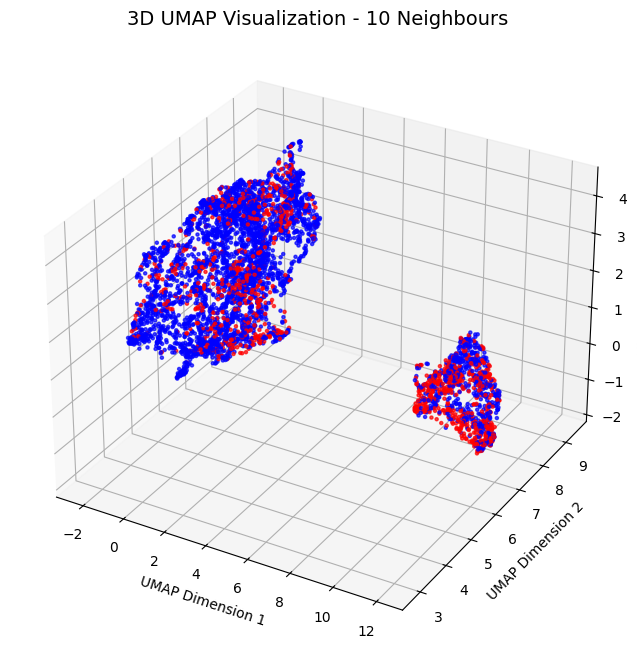

In [15]:
## UMAP Visualisation Plot ## 3D/ 10 Neighbours

from mpl_toolkits.mplot3d import Axes3D
## matplotlib does supper plotting in 3D
## but the implementation is slightly more complication than plotting a 2D visualisation
## do not concern yourself with the exact implementation. Just observe how the global structure looks like in 3D and compare it to 2D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_umap3[:, 0], df_umap3[:, 1], df_umap3[:, 2],
    c=y_small, cmap='bwr', s=5, alpha=0.7
)

ax.set_title("3D UMAP Visualization - 10 Neighbours", fontsize=14)
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")
ax.set_zlabel("UMAP Dimension 3")

plt.show()

In [16]:
## similarly for 3D, we want to observe how the global structure changes when we increase the number of neighbours.

umap4 = UMAP(n_neighbors = 100, n_components = 3, random_state= 1000)
df_umap4 = umap4.fit_transform(X_small)

/Users/kaironglee/projects/sds-workshop/sds_test_venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


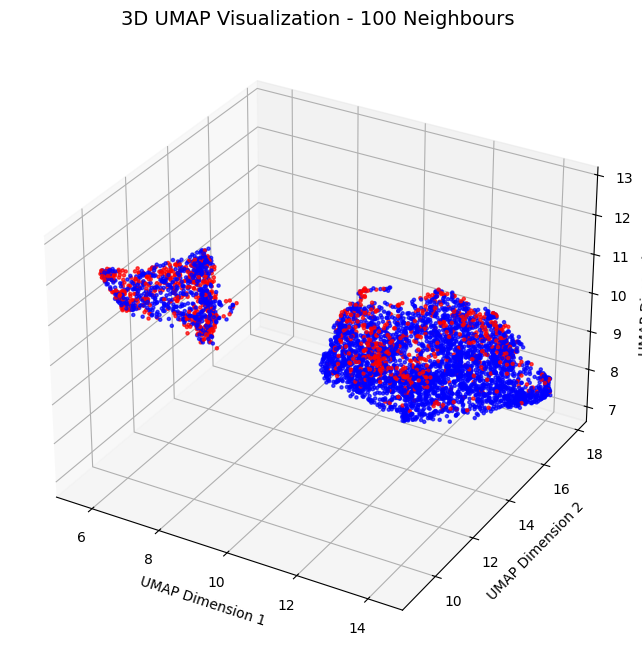

In [17]:
## UMAP Visualisation Plot ## 3D/100 Neighbours

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_umap4[:, 0], df_umap4[:, 1], df_umap4[:, 2],
    c=y_small, cmap='bwr', s=5, alpha=0.7
)

ax.set_title("3D UMAP Visualization - 100 Neighbours", fontsize=14)
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")
ax.set_zlabel("UMAP Dimension 3")

plt.show()

# t-SNE - Optional

There are a few hyperparamters for the tSNE function. Feel free to play around with them.

1. n_components
    - Number of dimensions in the low-dimensional embedding (usually 2 for visualization, 3 for 3D).
    - Note: Just like UMAP, the components in t-SNE do not have direct interpretable meaning.

2. perplexity
    - Roughly determines the number of effective neighbors each point considers in high-dimensional space.
    - Small perplexity → focuses on local structure (fine-grained clusters).
    - Large perplexity → captures more global structure.
    - Typical values: 5–50.

3. n_iter
    - Number of iterations of the gradient descent optimization.
    - Too few iterations → embedding may not converge; clusters may look messy.
    - More iterations → better convergence, but longer runtime.
    - Default is usually 1000.

4. learning_rate
    - Controls the step size during gradient updates.
    - Too small → slow convergence, possible “crowding” issues.
    - Too large → unstable embedding; points may scatter.
    - Default is usually 200.

5. early_exaggeration
    - Temporarily increases attractive forces in the initial optimization phase.
    - Helps form **tight clusters early**, making the structure more distinct.
    - Default is usually 12.0.

6. metric
    - Distance metric in the high-dimensional space.
    - Options:
        - 'euclidean' (default, used in this workshop)
        - 'manhattan' / 'cityblock' (alternative)
        - 'cosine' (less commonly used)

(a) 2D Plots

In [18]:
from sklearn.manifold import TSNE #tSNE library in python

tsne = TSNE(n_components=2, verbose=1, perplexity = 40 , random_state=1000)
# the default perplexity for tSNE is 40. This means 40 effective neighbours



df_tsne = tsne.fit_transform(X_small) # this function does the tSNE decomposition for you

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.332678
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.032631
[t-SNE] KL divergence after 1000 iterations: 1.981139


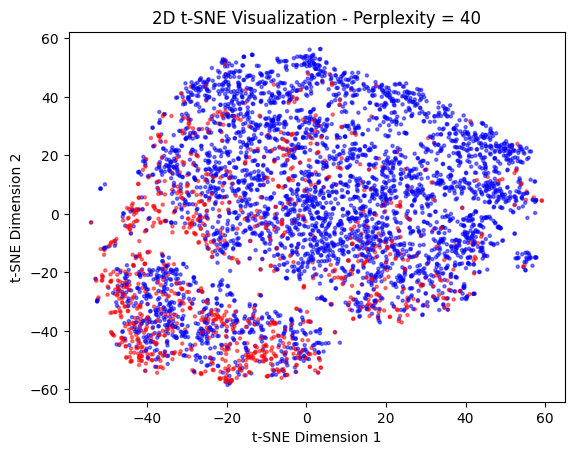

In [19]:
## t-SNE Visualisation Plot ## 2D/Perplexity = 40

plt.scatter(df_tsne[:,0], df_tsne[:,1], s = 5 , c = y_small ,cmap = 'bwr', alpha = 0.5)
plt.title('2D t-SNE Visualization - Perplexity = 40')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [20]:
## Similar to UMAP, we want to observe how the clusters change when we increase the perplexity
## A larger perplexity indicates more effective neighbours and thus captures the global structure better
## However, in contrast to UMAP, a higher perplexity does not really affect the runtime of the algorithm.
## tSNE is still by far the slowest algorithm and much much slower than UMAP.

tsne2 = TSNE(n_components=2, perplexity = 50, verbose = 1, random_state = 1000)
df_tsne2 = tsne2.fit_transform(X_small)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.379859
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.089676
[t-SNE] KL divergence after 1000 iterations: 1.941199


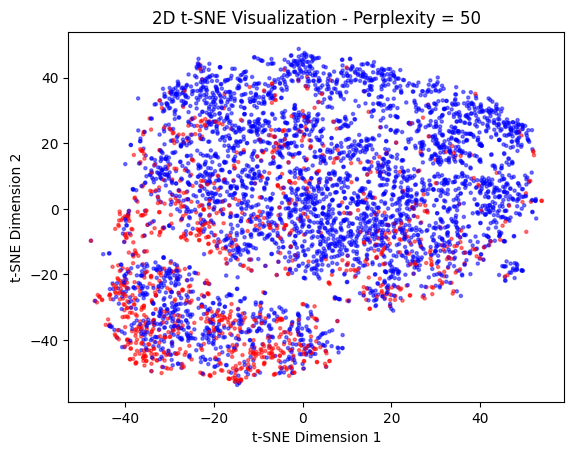

In [21]:
## t-SNE Visualisation Plot ## 2D/Perplexity = 50

plt.scatter(df_tsne2[:,0], df_tsne2[:,1], s = 5 , c = y_small ,cmap = 'bwr', alpha = 0.5)
plt.title('2D t-SNE Visualization - Perplexity = 50')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## 3D plots

In [22]:
## Similary to UMAP, we might miss our important structures in the data when you only visualise in 2 dimensions.
## It is often useful to do a 3D plot along with your 2D plot to analyse the overall structure of the data.
## This is done by changing n_components from 2 to 3.

tsne3 = TSNE(n_components=3, perplexity = 40, verbose = 1, random_state=1000)

df_tsne3 = tsne3.fit_transform(X_small)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.332678
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.085373
[t-SNE] KL divergence after 1000 iterations: 1.766245


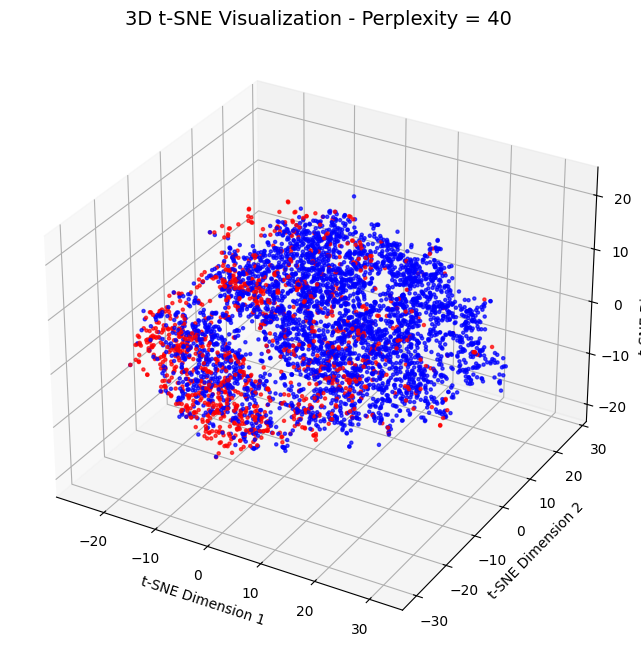

In [23]:
## t-SNE Visualisation Plot ## 3D/Perplexity = 40

## Implementation wise, this is the same as plotting a 3D UMAP visualisation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_tsne3[:, 0], df_tsne3[:, 1], df_tsne3[:, 2],
    c=y_small, cmap='bwr', s=5, alpha=0.7
)

ax.set_title("3D t-SNE Visualization - Perplexity = 40", fontsize=14)
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")


plt.show()

In [ ]:
# Here we change the perplexity to 50 and visualise in 3D

tsne4 = TSNE(n_components=3, perplexity = 50, verbose = 1 ,random_state = 1000)

df_tsne4 = tsne3.fit_transform(X_small)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.332678


Text(0.5, 0, 't-SNE Dimension 3')

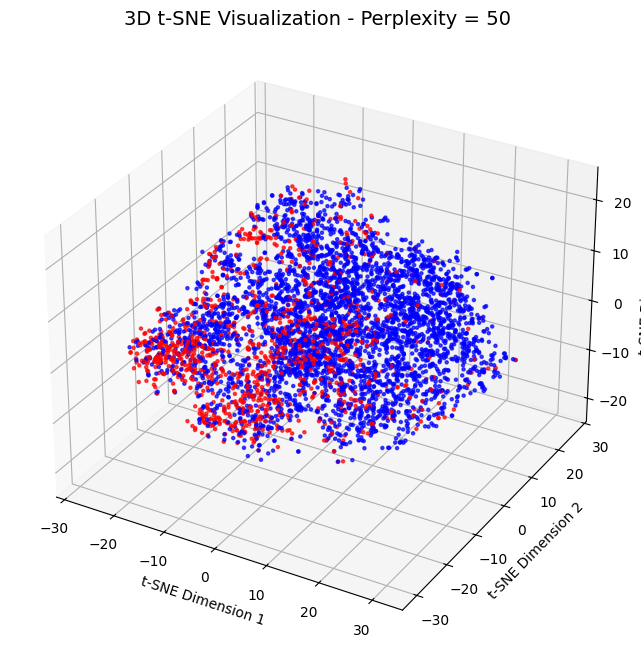

In [ ]:
## t-SNE Visualisation Plot ## 3D/Perplexity = 50

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_tsne4[:, 0], df_tsne4[:, 1], df_tsne4[:, 2],
    c=y_small, cmap='bwr', s=5, alpha=0.7
)

ax.set_title("3D t-SNE Visualization - Perplexity = 50", fontsize=14)
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")
